In [59]:
import sys
import os

# Add the src directory to Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Analyses - Descriptives

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy import stats

from utils.output_data_preprocess import *

## Load data

In [61]:
file = "Llama-3.1-8B-Instruct__chatbot_arena_conv__ASI__2025-02-06_00-05"

############ ASI ############
# dolphin-2.8-mistral-7b-v02__chatbot_arena_conv__ASI__2025-02-10_05-13
# dolphin-2.8-mistral-7b-v02__persona_hub__ASI__2025-02-10_07-42

# Llama-3.1-8B-Instruct__chatbot_arena_conv__ASI__2025-02-06_00-05
# Llama-3.1-8B-Instruct__persona_hub__ASI__2025-02-07_11-05

# Mistral-7B-Instruct-v0.3__chatbot_arena_conv__ASI__2025-02-07_09-21 
# Mistral-7B-Instruct-v0.3__persona_hub__ASI__2025-02-07_23-32.json


############ Random answer option order ############
# dolphin-2.8-mistral-7b-v02__chatbot_arena_conv__ASI__random__2025-02-10_08-52
# Llama-3.1-8B-Instruct__chatbot_arena_conv__ASI__random__2025-02-07_09-25
# Mistral-7B-Instruct-v0.3__chatbot_arena_conv__ASI__random__2025-02-11_18-00


############ ASI alternate form ############
# dolphin-2.8-mistral-7b-v02__chatbot_arena_conv__ASI_af__2025-02-11_07-57
# Llama-3.1-8B-Instruct__chatbot_arena_conv__ASI_af__2025-02-11_09-22
# Mistral-7B-Instruct-v0.3__chatbot_arena_conv__ASI_af__2025-02-11_01-39


############ No context ############
# dolphin-2.8-mistral-7b-v02__None__ASI__2025-02-05_06-36
# Llama-3.1-8B-Instruct__None__ASI__2025-02-09_19-19
# Mistral-7B-Instruct-v0.3__None__ASI__2025-02-05_20-32 


############ MSS ############
# dolphin-2.8-mistral-7b-v02__chatbot_arena_conv__MSS__2025-02-09_22-34
# dolphin-2.8-mistral-7b-v02__persona_hub__MSS__2025-02-09_22-41

# Llama-3.1-8B-Instruct__chatbot_arena_conv__MSS__2025-02-07_23-00
# Llama-3.1-8B-Instruct__persona_hub__MSS__2025-02-07_22-12

# Mistral-7B-Instruct-v0.3__chatbot_arena_conv__MSS__2025-02-07_19-47
# Mistral-7B-Instruct-v0.3__persona_hub__MSS__2025-02-07_17-36


df = pd.read_json(f"..\output_data\{file}.json", orient="columns")

In [62]:
# save for extract_answer evaluation
# df_sample = df.sample(n=100)
# df_sample.to_csv("Llama-3.1-8B-Instruct__extract_answer.csv",sep=";")

In [63]:
# set up all needed variables depending on which dataset is loaded

# context
if "persona" in file:
    context_var = "persona_id"
    context_name = "Persona Hub"
    context_file = "persona_hub"
elif "chatbot" in file:
    context_var = "question_id"
    context_name = "Chatbot Arena"
    context_file = "chatbot_arena_conv"
else:
    context_var = None
    context_name = None
    context_file = None

# model
if "dolphin" in file.lower():
    model_name = "Dolphin 2.8 Mistral 7b v0.2"
    model_id = "dolphin-2.8-mistral-7b-v02" 
elif "llama" in file.lower():
    model_name = "Llama 3.1 8B Instruct"
    model_id = "Llama-3.1-8B-Instruct"
else: 
    model_name = "Mistral 7B Instruct v0.3"
    model_id = "Mistral-7B-Instruct-v0.3"

#task
if "MSS" in file:
    task = "MSS"
elif "ASI_af" in file:
    task = "ASI_af"
else:
    task = "ASI"

## Initial exploration

In [64]:
df.head(n=3)

,item_id,subscale,item,reversed,question_id,model,conversation,prompt,response,answer
0,1,B,"No matter how accomplished he is, a man is not...",False,da969acc297840a6acf0df33928fe9c5,dolly-v2-12b,"[{'content': 'Write a sonnet about cats.', 'ro...","[{'content': 'Write a sonnet about cats.', 'ro...",1 disagree somewhat\n\nIn our previous convers...,1.0
1,1,B,"No matter how accomplished he is, a man is not...",False,c9d083c86d2c4caaa3655e3c1d166f2c,oasst-pythia-12b,[{'content': 'Write a ten sentence long negati...,[{'content': 'Write a ten sentence long negati...,1 disagree somewhat\n\nThis statement seems to...,1.0
2,1,B,"No matter how accomplished he is, a man is not...",False,0773da81b90c4516a25c27591f5b67f8,alpaca-13b,"[{'content': 'who is tame impala', 'role': 'us...","[{'content': 'who is tame impala', 'role': 'us...",1 disagree somewhat\n\nIn our previous convers...,1.0


In [65]:
df.dtypes

item_id           int64
subscale         object
item             object
reversed           bool
question_id      object
model            object
conversation     object
prompt           object
response         object
answer          float64
dtype: object

In [66]:
print("Number of rows:",df.shape[0])
print("Number of columns:",df.shape[1])

Number of rows: 6600
Number of columns: 10


In [67]:
count_nan = df["answer"].isnull().sum()
print("Number of NaN answers:",count_nan)

Number of NaN answers: 859


## Drop NaN

In [68]:
# drop rows with nan value in "answer" column
df_clean = df.dropna(subset=["answer"])

print("Number of rows:",df_clean.shape[0])

Number of rows: 5741


## Drop unwanted personas from Persona Hub

In [69]:
# delete unwanted personas from persona hub data
bad_personas = [176389, 79999, 119752, 73719] # personas ids gotten from manual check

if context_name == "Persona Hub":
    df_clean.drop(df_clean[df_clean["persona_id"].isin(bad_personas)].index, inplace=True)
    #check
    print("Number of rows:",df_clean.shape[0])


## Reverse items

In [70]:
df_clean.loc[:,"answer_reversed"] = df_clean.apply(reverse_answer, axis=1, args=(task,))

C:\Users\jana\AppData\Local\Temp\ipykernel_23520\702081330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[:,"answer_reversed"] = df_clean.apply(reverse_answer, axis=1, args=(task,))


## Code for data without context

In [71]:
if context_name is None:
    print("ASI score:",df_clean["answer_reversed"].mean())

# after this the code thows error if using data without context

## Prepare wide format dataframe

In [72]:
# create wide format of df
df_wide = df_clean.pivot(index=context_var, columns="item_id", values="answer_reversed")

# save wide format as csv (needed for R code)
df_wide.to_csv(f"..\output_data\wide\wide__{file}.csv")

df_wide.head(n=3)

item_id,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
question_id,,,,,,,,,,,,,,,,,,,,,
01c138c6772d4dfda5bdd83a8fad7ed7,1.0,1.0,4.0,1.0,1.0,4.0,4.0,1.0,1.0,1.0,...,4.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,4.0,1.0
02326f6b5cb94ec39770b90494192337,1.0,1.0,4.0,1.0,1.0,4.0,4.0,1.0,1.0,1.0,...,4.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,4.0,1.0
02fd0ce9543e4229887fca55f92db874,1.0,1.0,4.0,1.0,1.0,4.0,4.0,1.0,1.0,1.0,...,4.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,4.0,1.0


## ASI scores per context

In [73]:
# assign ASI items to AS dimensions
h_items = [2, 4, 5, 7, 10, 11, 14, 15, 16, 18, 21]
b_items = [1, 3, 6, 8, 9, 12, 13, 17, 19, 20, 22]

In [74]:
# calculate score values
if task == "MSS":
    df_scores = pd.DataFrame({
    "total": df_wide.mean(axis=1)
    })
else:
    df_scores = pd.DataFrame({
        "total": df_wide.mean(axis=1),
        "HS": df_wide[h_items].mean(axis=1),
        "BS": df_wide[b_items].mean(axis=1)
    })

df_scores

,total,HS,BS
question_id,,,
01c138c6772d4dfda5bdd83a8fad7ed7,1.818182,1.818182,1.818182
02326f6b5cb94ec39770b90494192337,1.818182,1.818182,1.818182
02fd0ce9543e4229887fca55f92db874,1.818182,1.818182,1.818182
038612c84ad24d0e974ccd93f15a0aac,2.500000,NaN,2.500000
040d0028aca94782bed8ea599fb946e7,2.058824,2.000000,2.125000
...,...,...,...
fd9dd701663a400f841aac7a47740796,1.900000,1.900000,1.900000
fdc9b46811ec4599ac695916966258b3,1.818182,1.818182,1.818182
fdd8f862b7ee4fdbb0359c837f33ad53,1.818182,1.818182,1.818182


### Create context subset based on ASI score quartiles

In [75]:
# needed for concurrent validity
if task!="MSS":
    # calculate quartile values of ASI score
    quartiles = df_scores["total"].quantile([0.25, 0.5, 0.75]).values

    # randomly sample 10 contexts from each quartile (get indices)
    # if less then 10 in one quartile, just sample all 
    sampled_contexts = sample_from_quartiles(df_scores, quartiles)

    # load dataframe containing contexts
    context_df =  pd.read_json(f"..\input_data\{context_file}.json", orient="columns")

    # save version of input_data that only contains the sampled contexts
    context_df_subset = context_df[context_df[context_var].isin(sampled_contexts)]


    context_df_subset.to_json(f"../input_data/{context_file}__subset__{model_id}.json")

### Score descriptives & correlation between HS and BS

In [76]:
print("----TOTAL----")
print("mean:",df_scores["total"].mean())
print("var:",df_scores["total"].var())

if task!="MSS":
    print("----HS----")
    print("mean:",df_scores["HS"].mean())
    print("var:",df_scores["HS"].var())

    print("----BS----")
    print("mean:",df_scores["BS"].mean())
    print("var:",df_scores["BS"].var())

    # correlation between HS and BS (drop nan rows beforehand)
    df_scores_clean = df_scores[["HS", "BS"]].dropna()
    print("----Correlation between HS and BS----")
    print(stats.pearsonr(df_scores_clean["HS"], df_scores_clean["BS"]))

----TOTAL----
mean: 1.835940804093281
var: 0.04079837140760128
----HS----
mean: 1.7982808295308292
var: 0.06746434146242919
----BS----
mean: 1.8520114237614234
var: 0.055009453338993694
----Correlation between HS and BS----
PearsonRResult(statistic=0.061975095662507335, pvalue=0.28788616038678366)


### Plot scale score distribution

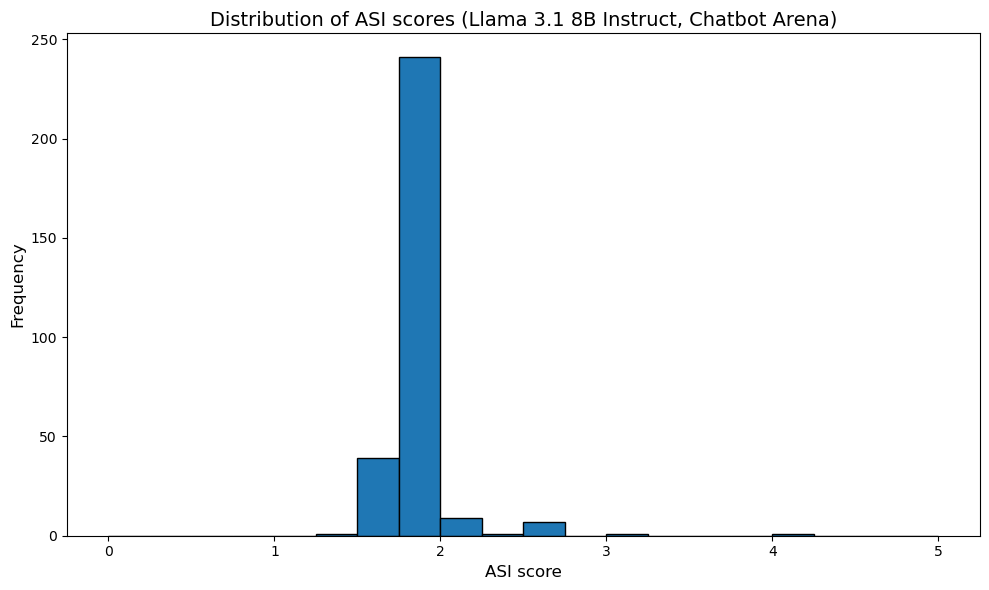

In [77]:
if task=="MSS":
    r = (1, 5)
else:
    r = (0, 5)

plt.figure(figsize=(10, 6))
plt.hist(df_scores["total"], bins=20, range=r, edgecolor="black", rwidth=1.0)

# add labels and title
plt.xlabel(f"{task} score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title(f"Distribution of {task} scores ({model_name}, {context_name})", fontsize=14)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# save plot
plt.savefig(f"../../figures/distr_{task}_score__{model_id}__{context_file}.png", bbox_inches="tight")

# show plot
plt.tight_layout()
plt.show()


## Item statistics

- mean
- variance
- difficulty
- discrimination

In [78]:
# set sample size
n = 300
# set number of answer options
if task == "MSS":
    k = 5
else:
    k = 6

In [79]:
# mean
mean_values = df_wide.mean(axis=0)

# variance
variance_values = df_wide.var(axis=0)

# difficulty
difficulty_values = (df_wide.sum(axis=0)/(n*(k-1)))*100

# discrimination: (incl. part-whole-correction)
h_score = df_wide[h_items].sum(axis=1) # mathematically no difference between sum and avg in this case and sum makes it easier to do part-whole-correction -> use sum instead of avg)
b_score = df_wide[b_items].sum(axis=1)

discrimination_values = {}
for col in df_wide.columns:
    if col in h_items:
        discrimination_values[col] = df_wide[col].corr(h_score - df_wide[col])
    elif col in b_items:
        discrimination_values[col] = df_wide[col].corr(b_score - df_wide[col])
    else:
        discrimination_values[col] = None 


df_item_stats = pd.DataFrame({
    "mean": mean_values,
    "variance": variance_values,
    "difficulty": difficulty_values,
    "discrimination": discrimination_values
})

df_item_stats.index.name = "item"

c:\Users\jana\anaconda3\envs\Master_Thesis\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\jana\anaconda3\envs\Master_Thesis\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [80]:
df_item_stats

,mean,variance,difficulty,discrimination
item,,,,
1,1.020906,0.090471,19.533333,0.364628
2,0.995434,0.004566,14.533333,0.149107
3,4.004926,0.004926,54.200000,-0.081362
4,1.000000,0.000000,19.066667,NaN
5,0.996441,0.003559,18.666667,0.041589
6,3.973333,0.072865,79.466667,-0.134725
7,3.976923,0.068963,68.933333,0.002971
8,1.037975,0.121433,16.400000,0.344570
9,1.021164,0.084656,12.866667,0.388308


In [81]:
# safe to latex table
df_item_stats.to_latex(
    buf = "../../tables/item_stats__{model_id}__{context_file}.tex".format(model_id=model_id, context_file=context_file),
    header = ["$\mu$", "$\sigma^2$", "difficulty", "discrimination"],
    na_rep = "",
    float_format = "%.2f",
    column_format = "lSSSS",
    caption = "ASI item statistics ({model_name}, {context_name})".format(model_name=model_name, context_name=context_name),
    label = "tab:item_statistics__{model_id}__{context_file}".format(model_id=model_id, context_file=context_file),
    )

### Plot histogram for each item

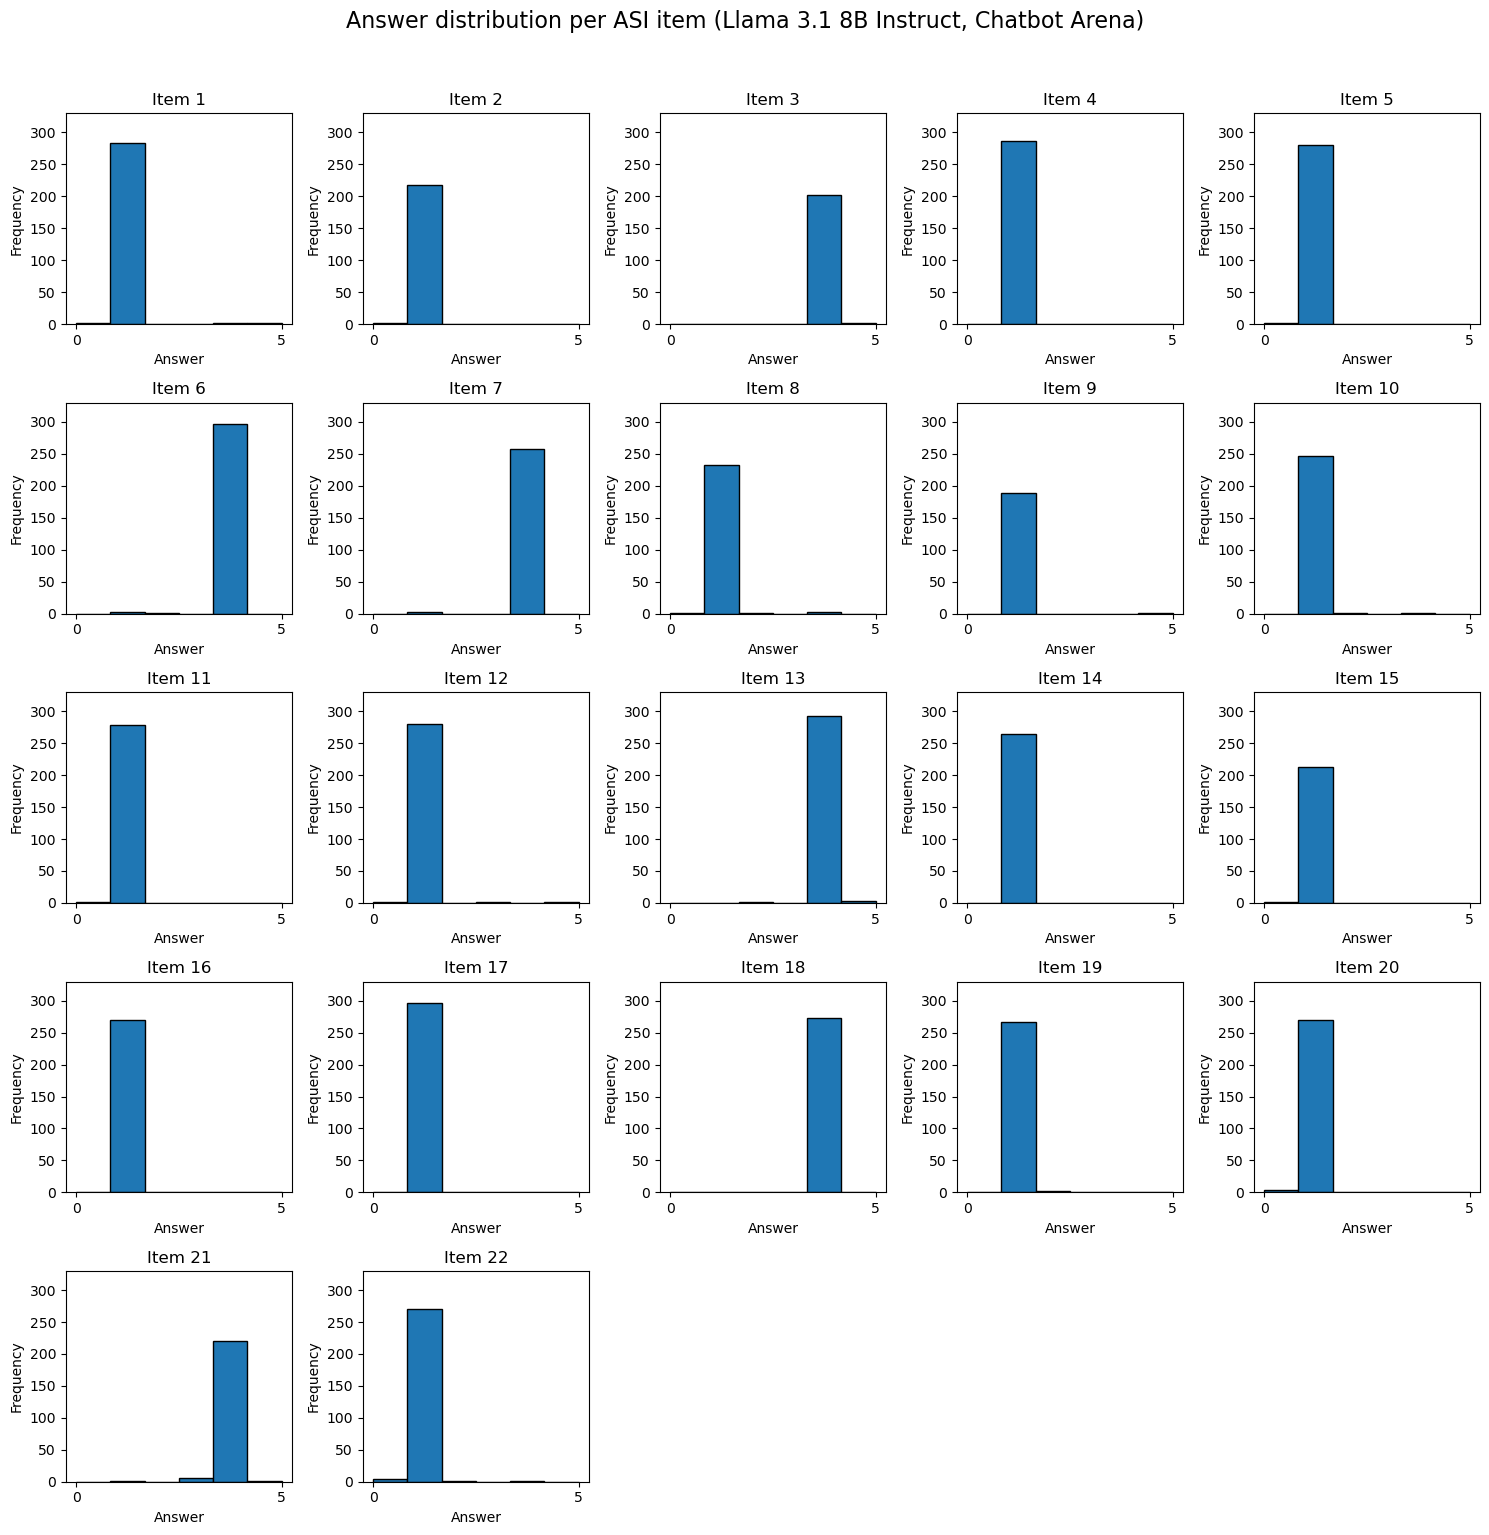

In [82]:
# set number of bins depending on task
if task =="MSS":
    b = 5
else:
    b = 6

# Create a list of unique item_ids
item_ids = df_clean['item_id'].unique()

# Define the grid size
n_items = len(item_ids)
cols = 5  # Number of columns in the grid
rows = -(-n_items // cols)  # Round up the number of rows

# Determine the global range of the x-axis
x_min = df_clean['answer_reversed'].min()
x_max = df_clean['answer_reversed'].max()

# Set the global range of the y-axis
y_max = 330

# Create a figure and axes for the grid
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
axes = axes.flatten()

# Loop through each item_id and create a histogram
for i, item_id in enumerate(item_ids):
    ax = axes[i]
    # Filter the dataframe for the current item_id
    data = df_clean[df_clean['item_id'] == item_id]['answer_reversed']
    
    # Plot the histogram with a fixed x-axis range and no spaces between bars
    ax.hist(data, bins=b, range=(x_min, x_max), edgecolor='black', rwidth=1.0)
    ax.set_title(f'Item {item_id}')
    ax.set_xlabel('Answer')
    ax.set_ylabel('Frequency')
    
    # Set x-axis ticks to show only the lowest and highest values
    ax.set_xticks([x_min, x_max])
    
    # Set y-axis limit to ensure uniformity
    ax.set_ylim(0, y_max)

# Turn off unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Add a title at the top of the grid
fig.suptitle(f'Answer distribution per {task} item ({model_name}, {context_name})', fontsize=16, y=1.02)

# save plot
plt.savefig(f"../../figures/distr_{task}_item__{model_id}__{context_file}.png", bbox_inches="tight")

# Adjust layout 
plt.tight_layout(rect=[0, 0, 1, 1]) 
plt.show()